This notebook imports the image data from shipsnet.json, trains a convolutional neural network (CNN) model, then exports it to model.h5, model.json, and weights.h5. The architecture of the CNN was copied from [this Kaggle notebook](https://www.kaggle.com/byrachonok/keras-for-search-ships-in-satellite-image/), which was the notebook with the most votes for this project.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.utils import np_utils  # convert target to categorical
from keras.preprocessing.image import ImageDataGenerator  # randomize images to create a larger training set
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import model_from_json, load_model

# visualize neural net
# from keras.utils.vis_utils import model_to_dot
# from IPython.display import SVG

from functions.image.image_tools import flat_image_to_array

In [3]:
to_save = False
np.random.seed(42)

In [4]:
# check that gpu is being used
# see: https://stackoverflow.com/questions/63415922/how-to-know-if-keras-is-using-gpu-or-cpu
print(device_lib.list_local_devices())
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16590286400342093287
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3219785174228720197
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7353095968
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2270513411973530000
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1446593108788672867
physical_device_desc: "device: XLA_GPU device"
]
2.2.0
Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Get Data

In [5]:
shipsnet_df = pd.read_json('data/shipsnet.json')
shipsnet_df['filename'] = shipsnet_df.apply(
    lambda x: f"{x['labels']}__{x['scene_ids']}__{x['locations'][0]}_{x['locations'][1]}",
    axis=1
)
shipsnet_df['image_array'] = shipsnet_df['data'].apply(flat_image_to_array)
shipsnet_df['normalized_image_array'] = shipsnet_df['image_array']/255

shipsnet_df

,data,labels,locations,scene_ids,filename,image_array,normalized_image_array
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47,1__20180708_180909_0f47__-118.2254694333423_33...,"[[[82, 94, 80], [89, 99, 86], [91, 101, 89], [...","[[[0.3215686274509804, 0.3686274509803922, 0.3..."
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e,1__20170705_180816_103e__-122.33222866289329_3...,"[[[76, 86, 70], [75, 85, 70], [67, 77, 64], [6...","[[[0.2980392156862745, 0.33725490196078434, 0...."
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06,1__20180712_211331_0f06__-118.14283073363218_3...,"[[[125, 136, 111], [127, 138, 114], [129, 140,...","[[[0.49019607843137253, 0.5333333333333333, 0...."
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a,1__20170609_180756_103a__-122.34784341495181_3...,"[[[102, 105, 87], [99, 101, 86], [113, 111, 97...","[[[0.4, 0.4117647058823529, 0.3411764705882353..."
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007,1__20170515_180653_1007__-122.34852408322172_3...,"[[[78, 82, 68], [76, 81, 67], [74, 79, 65], [7...","[[[0.3058823529411765, 0.3215686274509804, 0.2..."
...,...,...,...,...,...,...,...
3995,"[126, 122, 124, 138, 165, 186, 195, 199, 203, ...",0,"[-122.08693255500694, 37.77781408256089]",20170815_180821_102d,0__20170815_180821_102d__-122.08693255500694_3...,"[[[126, 103, 88], [122, 101, 87], [124, 103, 8...","[[[0.49411764705882355, 0.403921568627451, 0.3..."
3996,"[130, 134, 139, 128, 117, 126, 141, 147, 142, ...",0,"[-122.10549691828378, 37.76946626247702]",20170730_191230_0f21,0__20170730_191230_0f21__-122.10549691828378_3...,"[[[130, 122, 93], [134, 126, 97], [139, 129, 1...","[[[0.5098039215686274, 0.47843137254901963, 0...."
3997,"[171, 135, 118, 140, 145, 144, 154, 165, 139, ...",0,"[-122.48298739296371, 37.684929808845375]",20161116_180804_0e14,0__20161116_180804_0e14__-122.48298739296371_3...,"[[[171, 174, 171], [135, 138, 136], [118, 121,...","[[[0.6705882352941176, 0.6823529411764706, 0.6..."
3998,"[85, 90, 94, 95, 94, 92, 93, 96, 93, 94, 94, 9...",0,"[-122.29028216570079, 37.71632091139081]",20170211_181116_0e16,0__20170211_181116_0e16__-122.29028216570079_3...,"[[[85, 92, 83], [90, 98, 88], [94, 102, 94], [...","[[[0.3333333333333333, 0.3607843137254902, 0.3..."


# View a Sample Image

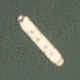

In [6]:
image_array = shipsnet_df['image_array'][0]
image = Image.fromarray(image_array)  # convert to PIL
image

# Prepare the Data

In [7]:
# train data
x = np.asarray(shipsnet_df['normalized_image_array'].to_list())
x

array([[[[0.32156863, 0.36862745, 0.31372549],
         [0.34901961, 0.38823529, 0.3372549 ],
         [0.35686275, 0.39607843, 0.34901961],
         ...,
         [0.34901961, 0.4       , 0.3372549 ],
         [0.32941176, 0.37647059, 0.31764706],
         [0.3254902 , 0.37647059, 0.32941176]],

        [[0.34901961, 0.39215686, 0.3372549 ],
         [0.35686275, 0.4       , 0.34509804],
         [0.34901961, 0.39607843, 0.34901961],
         ...,
         [0.39607843, 0.45098039, 0.38039216],
         [0.34117647, 0.39215686, 0.32941176],
         [0.34117647, 0.38823529, 0.3372549 ]],

        [[0.35686275, 0.39607843, 0.34509804],
         [0.36470588, 0.40784314, 0.36078431],
         [0.3372549 , 0.38431373, 0.33333333],
         ...,
         [0.3254902 , 0.37647059, 0.31764706],
         [0.35294118, 0.4       , 0.34509804],
         [0.36078431, 0.4       , 0.34901961]],

        ...,

        [[0.34901961, 0.38431373, 0.34117647],
         [0.34509804, 0.38431373, 0.3372549 ]

In [8]:
# train labels
y = np_utils.to_categorical(shipsnet_df['labels'], 2)
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [9]:
# See: https://keras.io/api/preprocessing/image/
# add exta images that are rotated 90 degrees and randomly flipped vertically or horizontally

datagen = ImageDataGenerator(rotation_range=90,
                             horizontal_flip=True,
                             vertical_flip=True)
datagen.fit(x)
x_extra, y_extra = next(datagen.flow(x, y, batch_size=1000, shuffle=True))

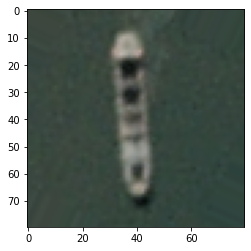

In [10]:
# sample one datagen image
fig = plt.figure()
ax = fig.gca()
ax.imshow(x_extra[0])

In [11]:
y_extra[0]

array([0., 1.], dtype=float32)

In [12]:
# concatenate original image dataset with additional rotated images

x_train = np.concatenate((x, x_extra))
y_train = np.concatenate((y, y_extra))

# Train NN

In [13]:
# define neural network
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [14]:
# compile
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train
# note: this is lightning fast with a GPU
model.fit(x_train, y_train,
          validation_split=0.2, shuffle=True,
          batch_size=32, # 32 photos at once
          epochs=18,
          verbose=2)

Epoch 1/18
125/125 - 4s - loss: 0.3922 - accuracy: 0.8330 - val_loss: 0.2721 - val_accuracy: 0.8800
Epoch 2/18
125/125 - 3s - loss: 0.2186 - accuracy: 0.9133 - val_loss: 0.2420 - val_accuracy: 0.9030
Epoch 3/18
125/125 - 4s - loss: 0.1774 - accuracy: 0.9317 - val_loss: 0.1671 - val_accuracy: 0.9360
Epoch 4/18
125/125 - 4s - loss: 0.1558 - accuracy: 0.9408 - val_loss: 0.2048 - val_accuracy: 0.9160
Epoch 5/18
125/125 - 4s - loss: 0.1421 - accuracy: 0.9470 - val_loss: 0.1626 - val_accuracy: 0.9330
Epoch 6/18
125/125 - 3s - loss: 0.1118 - accuracy: 0.9600 - val_loss: 0.1176 - val_accuracy: 0.9550
Epoch 7/18
125/125 - 3s - loss: 0.0927 - accuracy: 0.9632 - val_loss: 0.1652 - val_accuracy: 0.9370
Epoch 8/18
125/125 - 3s - loss: 0.0877 - accuracy: 0.9675 - val_loss: 0.1553 - val_accuracy: 0.9360
Epoch 9/18
125/125 - 4s - loss: 0.0737 - accuracy: 0.9737 - val_loss: 0.1395 - val_accuracy: 0.9540
Epoch 10/18
125/125 - 4s - loss: 0.0691 - accuracy: 0.9770 - val_loss: 0.1151 - val_accuracy: 0.9580

# Save

In [20]:
# option 1: save model and weights in h5
if to_save:
    model.save('models/model.h5')  # note: this is the same as .hdf5
loaded_model = load_model('models/model.h5')

# check equivalence
model.predict(x_train[0:3]) == loaded_model.predict(x_train[0:3])

array([[ True,  True],
       [ True,  True],
       [ True,  True]])

In [21]:
# option 2: save model in json and weights in h5

# save:
if to_save:
    with open("models/model.json", "w") as f:
        f.write(model.to_json())
    model.save_weights('models/weights.h5')

# load json and create model
with open("models/model.json") as f:
    loaded_model = model_from_json(f.read())
loaded_model.load_weights("models/weights.h5")

# check equivalence
model.predict(x_train[0:3]) == loaded_model.predict(x_train[0:3])

array([[ True,  True],
       [ True,  True],
       [ True,  True]])